In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from math import comb

plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

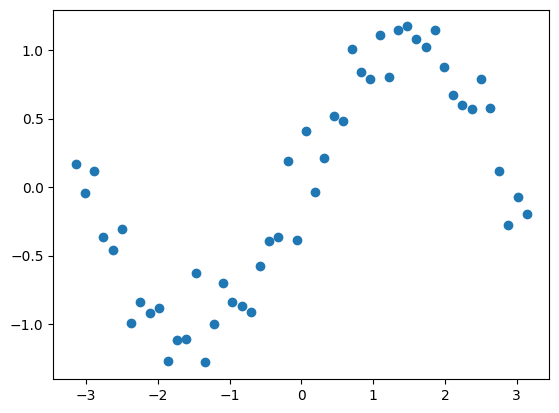

In [2]:
# Noisy training data
noise = 0.2
x = np.linspace(-np.pi, np.pi).reshape(-1, 1)
y0 = np.sin(x) + noise * np.random.randn(*x.shape)
fig, ax = plt.subplots()
ax.scatter(x, y0)
plt.show()

Using a radial basis function kernel (RBF) given by 
$$ k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2\ell^2} \right) + \sigma_n^2 I$$

In [3]:
# using the RBF Kernel
from sklearn.gaussian_process.kernels import RBF
rbf_kernel = 1.0 * RBF(0.5)

Using a quadratic kernel given by $$k(x_i, x_j) = \left(1 + \frac{d(x_i, x_j)^2 }{ 2\alpha  \ell^2}\right)^{-\alpha}$$

In [4]:
# Using a quadratic kernel given as
from sklearn.gaussian_process.kernels import RationalQuadratic
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)

Using a periodic kernel that restricts functions to periodic functions $$k(x_i, x_j) = \text{exp}\left(-\frac{ 2\sin^2(\pi d(x_i, x_j)/p) }{ l^ 2} \right)$$

In [5]:
from sklearn.gaussian_process.kernels import ExpSineSquared
periodic_kernel = ExpSineSquared(length_scale=1, periodicity=1)

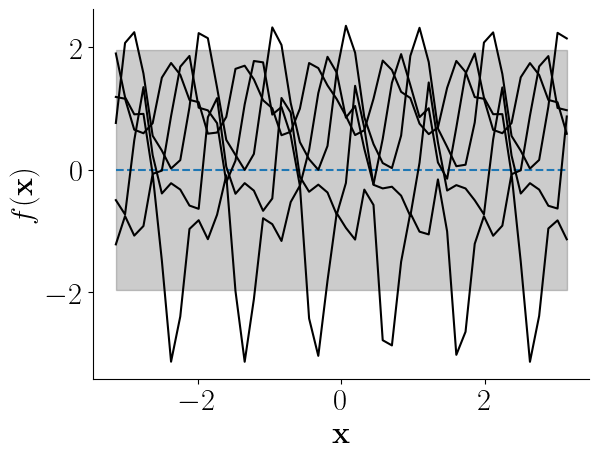

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor

GP = GaussianProcessRegressor(kernel=periodic_kernel,
                              random_state=0
                             )
mu_s, cov_s = GP.predict(x, return_cov=True)
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
samples = np.random.multivariate_normal(mu_s, cov_s, 5)

with plt.style.context(plt_style):
    fig, ax = plt.subplots()
    ax.plot(x, mu_s, label='Mean', ls='--')
    for s in samples:
        ax.plot(x, s, color='k')
    ax.fill_between(x.flatten(), 
                    mu_s+uncertainty, mu_s-uncertainty, 
                    color='k', 
                    alpha=0.2,
                    label=r'$3\sigma$'
                   )
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
#     plt.savefig('./figures/lec17_1.pdf')
    plt.show()    

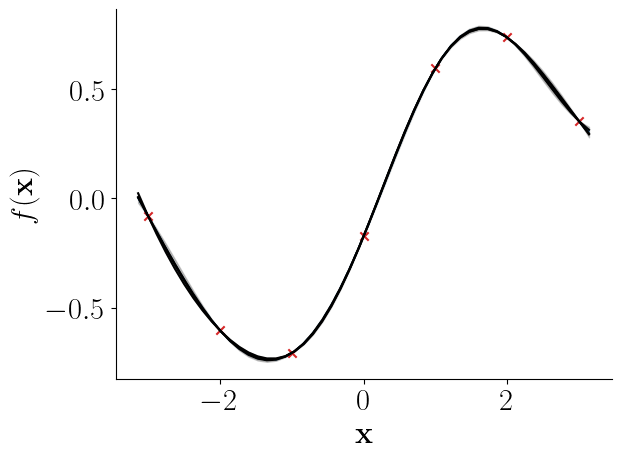

In [7]:
# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

GP.fit(X_train, Y_train)
mu_s, cov_s = GP.predict(x, return_cov=True)
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

samples = np.random.multivariate_normal(mu_s, cov_s, 3)

with plt.style.context(plt_style):
    fig, ax = plt.subplots()
    ax.plot(x, mu_s, label='Mean', ls='--')
    for s in samples:
        ax.plot(x, s, color='k')
    ax.fill_between(x.flatten(), 
                    mu_s+uncertainty, mu_s-uncertainty, 
                    color='k', 
                    alpha=0.2,
                    label=r'$3\sigma$'
                   )
    ax.scatter(X_train, Y_train, marker='x', color='tab:red')
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
#     plt.savefig('./figures/lec17_2.pdf')
    plt.show()

# Bayesian Additive Regression Trees

Bayesian way of thinking about this is to consider the model as 

$$y = f(x) + \epsilon $$ 

where we approximate $f$ using $m$ regression trees. Assuming the noise $\epsilon\sim\mathcal{N}(0,\sigma)$, we get the following probabilistic model for BART 

$$y \sim \mathcal{N}(\mu = BART(x), \sigma)$$

For detailed explanation of this method beyond what we covered in class, have a look at the following blog posts : [BART method](https://jmloyola.github.io/posts/2019/06/introduction-to-bart), [backfitting MCMC](https://jmloyola.github.io/posts/2019/07/posterior-inference-in-bart)

In [11]:
import pymc as pm
import xarray as xr
import pymc_bart as pmb
import arviz as az

RANDOM_SEED = 2023
rng = np.random.default_rng(RANDOM_SEED)

X = x
Y = y0.flatten()
with pm.Model() as model:
    μ = pmb.BART("μ_", X=X, Y=Y, m=200)
    sigma = pm.InverseGamma('σ', alpha=3/2, beta=0.5)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=sigma, observed=Y)
    idata = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ_]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.


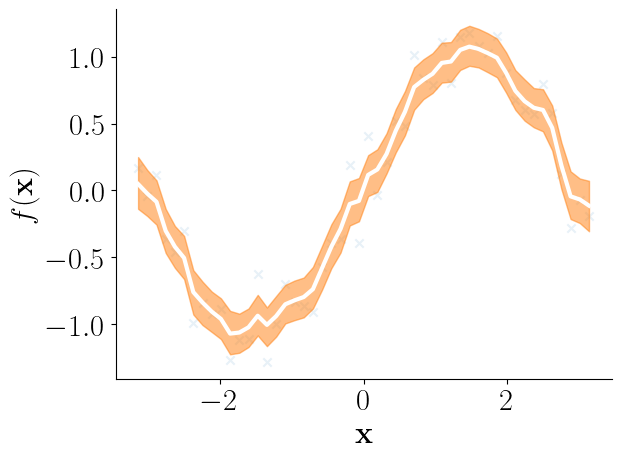

In [13]:
with plt.style.context(plt_style):    
    _, ax = plt.subplots()

    rates = idata.posterior["μ"]
    rate_mean = idata.posterior["μ"].mean(dim=["draw", "chain"])
    ax.scatter(x,Y, marker='x', alpha=0.1)
    ax.plot(x, rate_mean, "w", lw=3)
    az.plot_hdi(x.flatten(), rates, smooth=False)
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
#     plt.savefig('./figures/lec17_3.pdf')
    plt.show()